# Week 4 - Neural Networks

The type of Artificial Neural Network (ANN) we will use today is the multilayer perceptron (MLP). It is a feedforward neural network, where the input data is fed in only one direction (forward) through the network (without loops), and the output is generated at the end. In this scenario:
- The leftmost layer is the input layer
- The middle layer(s) are hidden layer(s)
- The rightmost layer is the output layer

The architecture of ANNs allows them to learn complex patterns from data by automatically extracting statistically significant features. This lets them be used to solve complex problems and uncover patterns and relationships within large datasets too complicated for traditional approaches.

Fun fact! Neural networks with non-linear activation functions can learn non-linear relationships. A neural network with infinite neurons can approximate any function - but that would be a pretty big network... For more information, check out [Universal Approximation Theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem)!

This notebook demonstrates how to implement an ANN with the following sections:
1. Loading the Dataset
2. NN Implementation with Scikit-Learn
3. NN Implementation with Pytorch
    1. Defining the Model
    2. Training the NN
    3. Evaluation
4. NN Implementation From Scratch
    1. Activation Functions
    2. Loss Functions
    3. Foward Propagation 
    4. Backpropagation
    5. Putting It All Together

## 1. Loading the Dataset

Before loading the dataset we need to import the following python packages. From the "Introduction to Python" session, we have introduced the various packages commonly used in machine learning: Numpy for numerical computations and supports working with arrays and matrices, Matplotlib for visualising data such as through graphical representations, Scikit-learn for using built-in models and datsets, Seaborn for more data visualisation, and lastly tqdm for adding process bars to loops. Feel free to check out the [introduction-to-python](https://github.com/UCLAIS/ML-Tutorials-Season-4/tree/main/week-0/introduction-to-python) session for more information.

In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from seaborn import heatmap
from tqdm.notebook import tqdm


In [2]:
# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

In [3]:
# this gives live loss plots -- recommended
from livelossplot import PlotLosses

We now also make sure we're using out computer GPU for best performance. Make sure it says "Using cuda device" below. If not, go to "Runtime" -> "Change runtime type" in google colab and change to GPU. This will make model training a lot faster!!

In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In this demonstration, we will be using the [MNIST](https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html) dataset, which includes 28x28 grayscale images of handwritten digits (0 through 9). The following function loads this dataset as numpy arrays to represent the images and an integer value for the label. Initially, the value of each pixel takes values between 0 and 255 - this may result in very large results from forward propagation computations, so it is important to scale this to between 0 and 1 by dividing by 255.

![title](media/MNIST.jpeg)

Since we are showing classification between only two classes in this session, we will filter out images that corresponds outside the two.

In [5]:
def load_mnist_dataset():
    # Load the datadet from SkDataset
    X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
    y = y.astype(np.int64)

    # Scale values between [0, 1]
    X = X / 255.0
    return X, y

The code below plots a confusion matrix, which evaluates the performance of a classification model by displaying the number of instances where we have true positive, true negative, false positive, and false negative predictions.

In [6]:
def plot_confusion_matrix(true_labels, pred_labels):
    fig, ax = plt.subplots(figsize=(10, 10))
    cm = confusion_matrix(true_labels, pred_labels)
    heatmap(cm, annot=True, ax=ax, cmap="Blues")
    ax.set_xlabel("Predicted labels")
    ax.set_ylabel("True labels")
    ax.set_title("Confusion Matrix")
    plt.show()

The following loads and splits the mnist dataset into training and testing. Each set would contain a series of examples (a pair of features and labels) that are fed into the model firstly for training to update the parameters for learning, and then the results are confirmed by the test set to show how well the model is performing. test_size of 0.2 means that 20% of the loaded dataset is used for testing and 80% is used for training.

In [7]:
X_mnist, y_mnist = load_mnist_dataset()
X_mnist_train, X_mnist_test, y_mnist_train, y_mnist_test = train_test_split(
    X_mnist, y_mnist, test_size=0.2, random_state=42
)

## 2. Neural Network Implemented with Scikit-Learn

MLPClassifier is a sklearn class that stands for Multi-Layer Perceptron Classifier with a prebuilt neural network-based classification algorithm that uses a multi-layer feedforward neural network. In this example, we have two hidden layers, each with 100 neurons and the algorithm will, at most, iterate through the training dataset 1000 times. Below is a graph showing how the loss has decreased throughout the iterations.

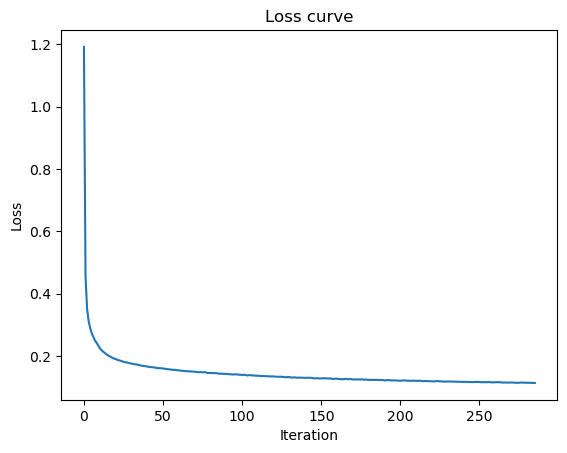

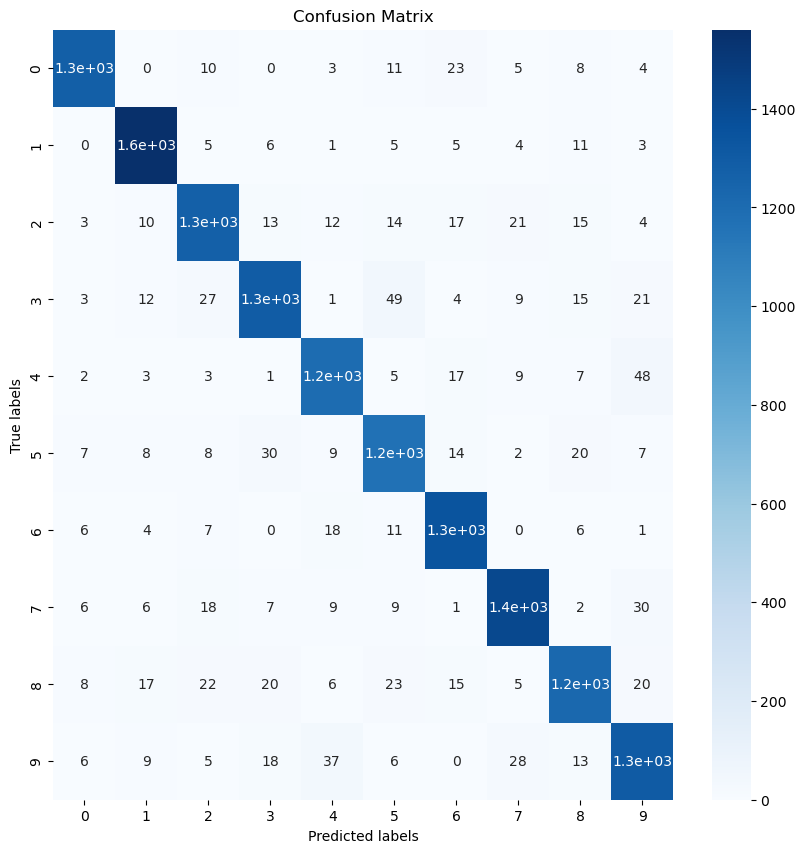

Accuracy: 93.19%


In [8]:
# Import the packages and classes needed in this example

from sklearn.neural_network import MLPClassifier

# Use the mnist dataset

mlp = MLPClassifier(hidden_layer_sizes=(10, 10), max_iter=1000)

# Train the neural network
mlp.fit(X_mnist_train, y_mnist_train)


# Plot the loss curve
plt.plot(mlp.loss_curve_)
plt.title("Loss curve")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

# Plot the predictions
y_pred = mlp.predict(X_mnist_test)
plot_confusion_matrix(y_mnist_test, y_pred)

# Accuracy
print(f"Accuracy: {np.mean(y_mnist_test == y_pred) * 100:.2f}%")

## 3. Neural Network Implemented with PyTorch

PyTorch is an ML framework developed by Meta AI, that includes built-in functions for building an NN by layers. The following code shows how we can define our model as a series of linear layers with ReLU activation functions.

### 3.1 Define our model

First we us PyTorch to define the model. Pytorch gives us a lot of flexibility including how many layers, the number of neurons in each layer, activation function, etc. More about the possible models and layers is available in the [documentation](https://pytorch.org/docs/stable/nn.html#linear-layers).

In [9]:
# Define our model with 3 hidden layers
num_input_features, num_hidden_neurons, num_classes = X_mnist.shape[1], 100, 10
model = nn.Sequential(
    nn.Linear(num_input_features, num_hidden_neurons),
    nn.ReLU(),
    nn.Linear(num_hidden_neurons, num_hidden_neurons),
    nn.ReLU(),
    nn.Linear(num_hidden_neurons, num_hidden_neurons),
    nn.ReLU(),
    nn.Linear(num_hidden_neurons, num_hidden_neurons),
    nn.ReLU(),
    nn.Linear(num_hidden_neurons, num_classes),
    nn.Softmax(dim=1)
)

# Move model to GPU is present
model = model.cuda() if device == "cuda" else model
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=100, bias=True)
  (5): ReLU()
  (6): Linear(in_features=100, out_features=100, bias=True)
  (7): ReLU()
  (8): Linear(in_features=100, out_features=10, bias=True)
  (9): Softmax(dim=1)
)


### 3.2 Training our neural network

First, we define the hyperparameter. Feel free to experiment with those!

In [10]:
learning_rate = 1e-2
batch_size = 32
num_epochs = 250

We use the cross_entropy loss function. This is best for multi-class classification problems such as this case. 

In [11]:
def loss_fun(pred, target):
    return nn.functional.cross_entropy(pred, target)

We also used the Adam optimeter here. This updates our weights based on the gradient values it receives in 'loss.backward()'. The specifics of how it does this is not too important. Just know this is an extended version of gradient descent.

In [12]:
optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

Finally we set up our model for training and plotting.

In [13]:

#Keep track of losses
plotlosses = PlotLosses()

# Convert our training data to tensors
X_mnist_train_tensor = torch.from_numpy(X_mnist_train).float().to(device)
y_mnist_train_tensor = torch.from_numpy(y_mnist_train).long().to(device)

# Change model to training mode
model.train();

Let's now actually train our model! 

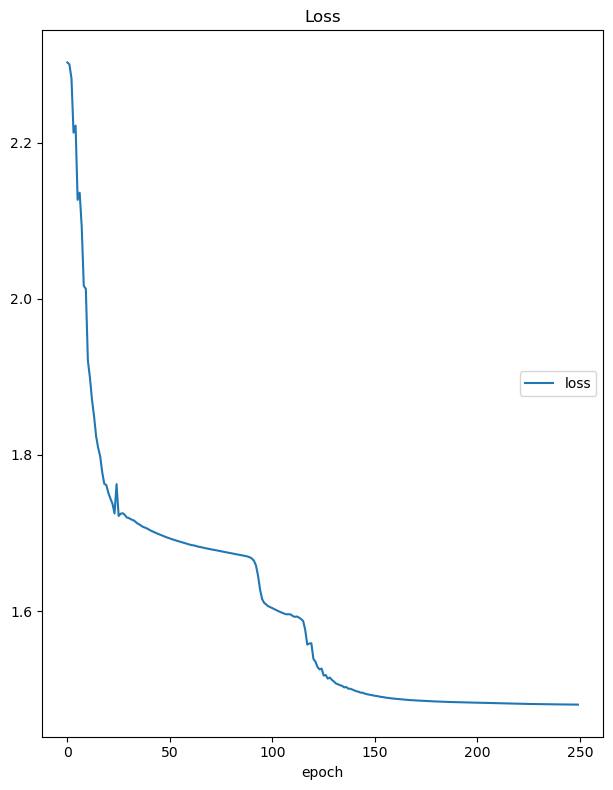

Loss
	loss             	 (min:    1.480, max:    2.303, cur:    1.480)


In [14]:

for _ in range(num_epochs):
    # Forward pass
    pred = model(X_mnist_train_tensor)

    # Compute loss
    loss = loss_fun(pred, y_mnist_train_tensor)

    # Backward pass
    optim.zero_grad() # Reset gradients
    loss.backward()

    # Gradient descent step
    optim.step() 

    # Update live plot
    plotlosses.update({"loss": loss.item()})
    plotlosses.send()

Notice how the loss is not a perfect "L" shape in this case, and we plateau a couple times around epochs 50-90 and 100-110. This is likely because we get stuck in a saddle point during our optimization stage. Proves to show sometimes it is best to wait longer for the model to train rather than stopping preemptively. 

### 3.3 Evaluating the output

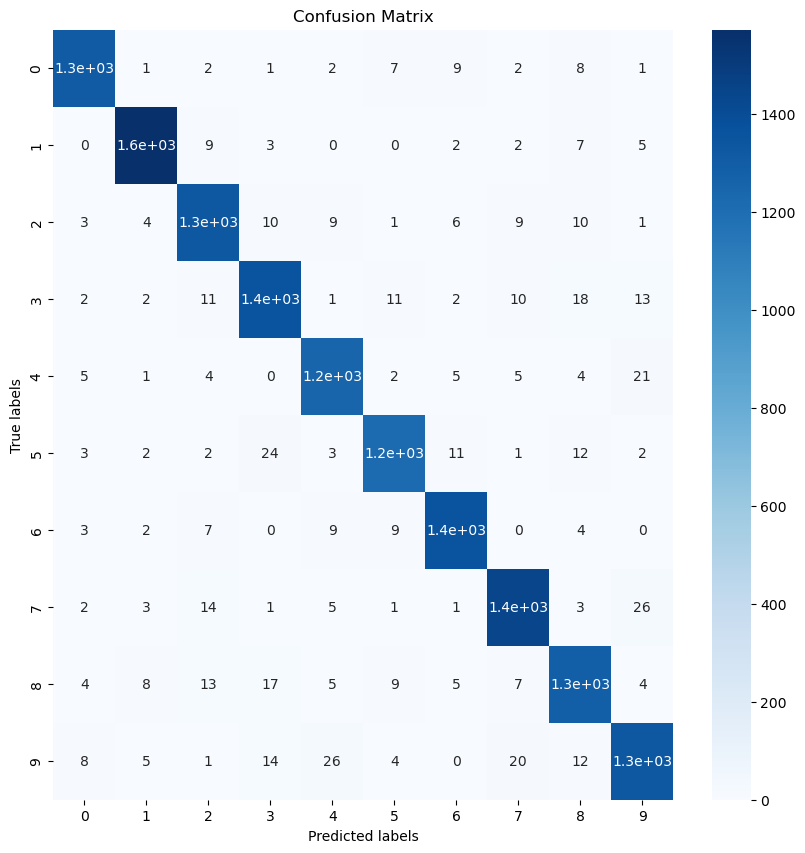

Accuracy: 96.12%


In [15]:

# Change model to evaluation model
model.eval()
with torch.no_grad():
    pred = model(torch.from_numpy(X_mnist_test).float().to(device))
    y_pred = pred.argmax(dim=1).cpu().numpy()
    plot_confusion_matrix(true_labels=y_mnist_test, pred_labels=y_pred)

# Accuracy
print(f"Accuracy: {np.mean(y_mnist_test == y_pred) * 100:.2f}%")

## 4. Neural Network Implemented From Scratch

Feel free to skip this section of the notebook if it is too advanced for you! This part shows how you could create your own NN without the use of any built-in functions. 

### 4.1 Activation Functions

Activation functions are used to allow relationships that are non-linear in nature. There are many activation functions, but the most common are the sigmoid function, the tanh function, and the rectified linear unit (ReLU) function. 

The sigmoid function is defined as follows:

$$\sigma(z) = \frac{1}{1+e^{-z}}$$

The tanh function is defined as follows:

$$\text{tanh}(z) = \frac{e^z - e^{-z}}{e^z + e^{-z}}$$

The ReLU function is defined as follows:

$$\text{ReLU}(z) = \text{max}(0,z)$$


In [16]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def tanh(z):
    return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))


def relu(z):
    return np.maximum(0, z)

### 4.2 Loss Functions

Loss functions are used to evaluate how well the model performs. We aim to minimise the loss function as much as possible. There are many loss functions, but the most common two are the mean squared error (MSE) and the binary cross entropy (BCE). The MSE is used for regression problems, while the BCE is used for classification problems.

The MSE is defined as:

$$\text{MSE}(\bf{y}, \bf{\hat{y}}) = \frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y_i})^2$$

where $y_i$ is the true value and $\hat{y_i}$ is the predicted value.

The BCE is defined as:

$$BCE = -y_1\log(\hat{y_1}) - (1 - y_1)\log(1 - \hat{y_1})$$

where $y_i$ is the true value and $\hat{y_i}$ is the predicted value.

In [17]:
def mse_loss(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)


def bce_loss(y_true, y_pred):
    # the epsilon value is used to avoid log(0) which is undefined
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -y_true * np.log(y_pred) - (1 - y_true) * np.log(1 - y_pred)

### 4.3 Forward Propagation

Forward propagation is a series of computations that takes the input layer and produces a prediction. This can be described mathematically in the following steps:

1. Get the output from the neuron $$z = Wx + b$$
2. Pass the output through an activation function A $$\hat{y} = A(z)$$

In [18]:
def forward(X, W, b):
    # This example is very simple, but we can have multiple hidden layers
    z = X @ W + b
    yhat = sigmoid(z)
    return yhat, z

### 4.4 Backpropagation

Backpropagation is used to update the weights and biases. These are done by computing the partial derivatives of the loss function with respect to the weights and biases. The formulae we use for this are:

$$ W_{n+1} = W_n - \alpha \frac{\partial L}{\partial W_n} $$
$$ b_{n+1} = b_n - \alpha \frac{\partial L}{\partial b_n} $$

where $\alpha$ is the learning rate.

This is done is essentially four steps:
1. Calculate $\frac{\partial L}{\partial \hat{y}}$ using the derivative of the loss function
2. Calculate $\frac{\partial \hat{y}}{\partial z}$ using the derivative of the activation function
3. Calculate $\frac{\partial z}{\partial W}$ and $\frac{\partial z}{\partial b}$ using the derivative of the forward pass
4. Use the chain rule to calculate $\frac{\partial L}{\partial W}$ and $\frac{\partial L}{\partial b}$

In [19]:
def d_mse_loss(y_true, y_pred):
    grad = -2 * (y_true - y_pred) / len(y_true)
    return grad


def d_sigmoid(z):
    grad = sigmoid(z) * (1 - sigmoid(z))
    return grad


def backward(X, y, z, yhat, W, b):

    dL_dyhat = d_mse_loss(y, yhat)
    dyhat_dz = d_sigmoid(z)
    dz_dw = X
    dz_db = 1

    dL_dz = dL_dyhat * dyhat_dz
    dL_dw = dz_dw.T @ dL_dz
    dL_db = np.sum(dL_dz * dz_db, axis=0)

    dL_dw = dL_dw
    dL_db = dL_db

    return dL_dw, dL_db

### 4.5 Putting it all together
Now that we have set up all the components, we can assemble these pieces in our training function. This iterates over the number of epochs set, each time creating a random batch of 200 data points from arrays X and Y while ensuring that the selected indices are unique, applying forward propagation through the neural network, as well as backpropagation to update the parameters. The loss calculated in each epoch is saved into loss_history so that we can plot it on a graph.

In [20]:
def training(X, Y, W, b, step_size, max_it):

    loss_history = []
    for i in tqdm(range(max_it)):

        idx = np.random.choice(X.shape[0], 200, replace=False)
        X_batch = X[idx]
        Y_batch = Y[idx].reshape(-1, 1)

        yhat, z = forward(X_batch, W, b)
        loss = mse_loss(Y_batch, yhat)
        loss_history.append(loss)
        dL_dw, dL_db = backward(X_batch, Y_batch, z, yhat, W, b)
        W = W - step_size * dL_dw
        b = b - step_size * dL_db

    return W, b, loss_history

The code below combines the steps mentioned previously: spliting the dataset into test and training sets, defining the initial set-up for the neural network, training and lastly evaluating the performance looking at the loss graph. Feel free to change the learning rate, loss function and activation function used to explore how this might affect the output!

  0%|          | 0/2500 [00:00<?, ?it/s]

Final loss: 0.03327761134328305
Accuracy: 95.89%


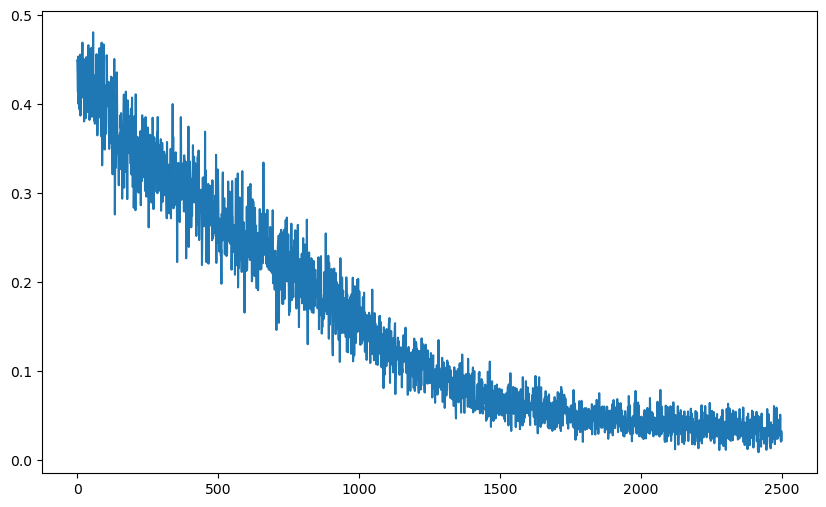

In [21]:
# Set the step size, maximum number of epochs, and classes
step_size = 0.01
max_iter = 2500
class1 = 0
class2 = 1


# Our example is binary, so let's simplify the problem and only look at 2 classes
X_subset = X_mnist_train[(y_mnist_train == class1) | (y_mnist_train == class2)]
Y_subset = y_mnist_train[(y_mnist_train == class1) | (y_mnist_train == class2)]
XT_subset = X_mnist_test[(y_mnist_test == class1) | (y_mnist_test == class2)]
YT_subset = y_mnist_test[(y_mnist_test == class1) | (y_mnist_test == class2)]


# We need to convert our labels to 0/1
Y_subset[Y_subset == class1] = 0
Y_subset[Y_subset == class2] = 1
YT_subset[YT_subset == class1] = 0
YT_subset[YT_subset == class2] = 1

# Set initial weights and biases to random values
initial_W = np.random.randn(X_subset.shape[1], 1)
initial_b = np.random.randn(1)

# Train the model
W, b, loss = training(X_subset, Y_subset, initial_W, initial_b, step_size, max_iter)

# Compute predictions and the model accuracy
y_pred, _ = forward(XT_subset, W, b)
final_loss = mse_loss(y_pred, YT_subset.reshape(-1, 1))
accuracy = np.mean(np.round(y_pred.flatten()) == YT_subset)

# Print results
print(f"Final loss: {final_loss}")
print(f"Accuracy: {accuracy * 100:.2f}%")

# Plot loss graph
fig = plt.figure(figsize=(10, 6))
plt.plot(loss)
plt.show()